# Los Angeles Weather Forecasting

## Introduction
Weather forecasting has long been a crucial endeavour in many distinct areas. 

Forecasting future weather has been a criticial task to enhance the quality of human life and preventing financial losses.

Also; it has been important to correctly forecast weather in order to increase efficiency and avoid possible accidents in many distinct sectors like agriculture and aviation.

In agriculture for example, unpredicted bad weather can cause crops to go wasted. However, if the weather conditions can be predicted; there are many procautions farmers can take to protect their crops.

There are many diferent methods for forecasting the future weather. However, this project focuses specifically on usage of time series analysis to make forecasts.

### DISCLAIMER:
Weather data used for training in this project is generated by [NOAA](https://www.noaa.gov/).

NOAA data can be used without any further permission as stated in [Use of Digital Media created by NOAA](https://sos.noaa.gov/copyright/#:~:text=A%20recording%20may%20be%20reproduced,obtained%20from%20the%20copyright%20owner).

Test Data is generated by Meteostat(Attribution: **'Source: Meteostat'**).
Copyright info: Meteostat data is available under the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License (CC BY-NC 4.0).


## Defining The Task

Minimum and maximum temperature ranges of Los Angeles City for the next 31 days will be calculated by using time series and machine learning methods on 50 years of weather data recorded at a station(GHCND:USW00023174) located in the LOS ANGELES INTERNATIONAL AIRPORT.

Forecast Origin: June 17, 2022 (Last data-point available recorded in the dataset)

Forecast Horizon: Next 31 days (June 17 - July 17) temperatures will be forecasted

Lead Time: 0 days


## Importing Necessary Libraries

In [1]:
# Upgrade statsmodels to get the function DeterministicProcess
!pip install --upgrade --no-deps statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 7.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Libraries for Data Manipulation
import pandas as pd
import numpy as np

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Analysis Libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier
from statsmodels.graphics.tsaplots import seasonal_plot
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
import math
from math import sqrt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# For System and Terminal Bash control
import os
from warnings import simplefilter

## Data Preperation



### Loading The data

The data has been sent by NOAA through e-mail after requesting an order from [CDO](https://www.ncei.noaa.gov/cdo-web/)

To avoid manuelly uploading data in every session, the data has been uploaded to Google Drive as publicly available. The code in the cell below will download the file with the specified id from Google drive. 

The data can also be manuelly downloaded through the link: [LA Weather Data](https://drive.google.com/uc?id=1O-7DuL6-bkPBpz7mAUZ7M62P6EOyngG2)

In [3]:
!gdown 16D876nRWTTWd0WNXWb5cgNVhL5Y_xamu

Downloading...
From: https://drive.google.com/uc?id=16D876nRWTTWd0WNXWb5cgNVhL5Y_xamu
To: /content/Train_data.csv
100% 1.77M/1.77M [00:00<00:00, 170MB/s]


### Understanding The Data

The downloaded data is in csv form. To open a csv file in a Pandas DataFrame form, read_csv function of Pandas module has been used.


In [4]:
weather_data = pd.read_csv("Train_data.csv")
weather_data.head()

,Unnamed: 0,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,0,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-01,NaN,0.0,0.0,0.0,NaN,73.0,62.0
1,1,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-02,NaN,0.0,0.0,0.0,NaN,71.0,62.0
2,2,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-03,NaN,0.0,0.0,0.0,NaN,70.0,61.0
3,3,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-04,NaN,0.0,0.0,0.0,NaN,73.0,61.0
4,4,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",1972-07-05,NaN,0.0,0.0,0.0,NaN,72.0,60.0


There are 18262 rows and 10 columns representing 18262 days (every day between 1972, july and 2022, june) and 10 features.

Features AWND	PRCP	SNOW	SNWD	TAVG	TMAX	TMIN represent the daily weather measurements conducted in the Los Angeles Airport in the specified date for each row.

### Handling the null values

The code below will show how many null (missing data) values are in data for each column.

In [5]:
weather_data.isnull().sum(axis = 0)

Unnamed: 0        0
STATION           0
NAME              0
DATE              0
AWND           4204
PRCP              0
SNOW           9118
SNWD           8449
TAVG          12219
TMAX              0
TMIN              0
dtype: int64

AWND, SNOW and SNWD columns are dropped because of too frequent null values present in these columns.

Station and name columns are also dropped because they have little importance on the task.

Remaining DATE, TMIN and TMAX columns will be used in the analysis.

In [6]:
weather_data = weather_data[["DATE", "TMIN","TMAX"]]

Columns have been renamed for better readability.

In [7]:
weather_data.columns = ["Date", "TMin", "TMax"]

TMin and TMax columns are recorded in Fahrenhait. 

The code below will augment new columns for celcius and kelvin.

In [8]:
# turn the data to Kelvin
weather_data.loc[:,"TMinK"] = ((weather_data["TMin"] -32)* 5/9 + 273.15).map(lambda x:int(x))
weather_data.loc[:,"TMaxK"] = ((weather_data["TMax"] -32)* 5/9 + 273.15).map(lambda x:int(x))

# Also add Celcius columns
weather_data.loc[:,"TMinC"] = ((weather_data["TMin"] -32)* 5/9 ).map(lambda x:int(x))
weather_data.loc[:,"TMaxC"] = ((weather_data["TMax"] -32)* 5/9 ).map(lambda x:int(x))

# add fahrenhait columns
weather_data.loc[:,"TMinF"] = ((weather_data["TMin"]).map(lambda x: int(x)))
weather_data.loc[:,"TMaxF"] = ((weather_data["TMax"]).map(lambda x: int(x)))

### Global Variables

In [9]:
# Global variables
colors = ["Orange", "Blue"]
skip_days = 50 # plot once for 50 days to reduce x density
x_tick_step = 11 # there will be 11 labels in total in the plot

#### Setting the unit
Below cell sets the unit; enter following letters for selecting the unit


*   K: Kelvin
*   C: Celcius
*   F: Fahranhait

In [10]:
unit = "C"

### Trimming the Data

The analysis will be conducted over the specified unit above(Celcius). Therefore previously augmented columns for other temperature units are redundant and will be removed from the dataset to ease the computation. 

In [11]:
weather_data = weather_data[["Date", "TMin"+unit,	"TMax" + unit]]

### Setting the index of dataset

The Date column has been set as index.

In [12]:
# Set the index as the column "Date"
weather_data = weather_data.set_index("Date") 

### Plotting the Data 

Data will be plotted for visual reference of the data.

In [13]:
# Some Plot Stylings
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

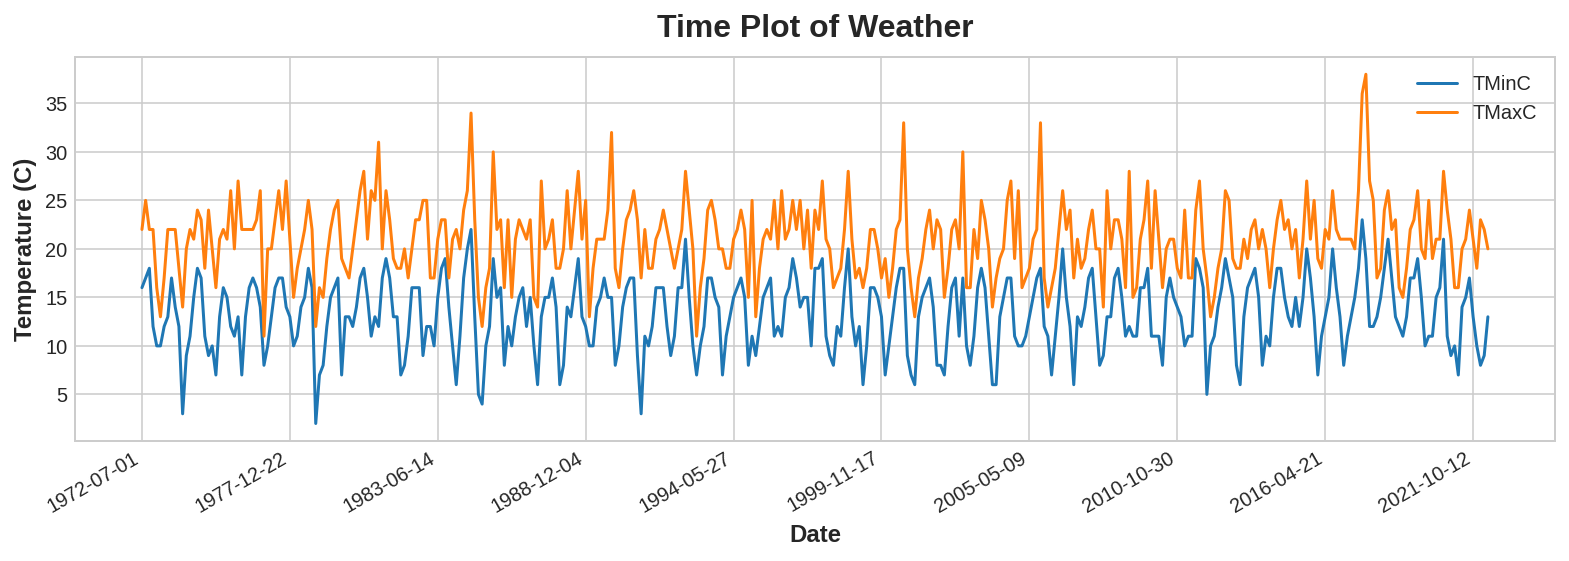

In [14]:
fig, ax = plt.subplots()
for i,col in enumerate(weather_data.columns):
  # plot temperatures against date
  ax.plot(weather_data[::skip_days].index, col, data=weather_data[::skip_days])

# set labels
ax.set_xlabel("Date")
ax.set_ylabel("Temperature ("+unit+")")

# set ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(x_tick_step))

ax.legend()
fig.autofmt_xdate()
ax.set_title('Time Plot of Weather');

## Machine Learning

**Method:** Possible trend, seasonality and seriel dependences will be calculated individually. Afterwards, results of these independently calculated methods will be combined to get a single prediction.

### Trend
Trend component of a time series represents a persistent, long-term change in the mean of the series.

In the case of weather analysis; the trend is expected to be linear with a slightly(about 0.08 Celcius per decade or .4 celcius in the span of 50 years) positive slope (src: [ NOAA - Climate.gov](https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature)).

The cell below will calculate first order(linear trend) in the data using a deterministic process.

In [15]:
dp_trend = DeterministicProcess(
    index = weather_data[::].index,          # Date values
    constant = True,                         # Bias
    order=1,                                 # Linear Trend
    drop=True                                # Drop terms if necessary to avoid collinearity
)
# in_sample creates features for the dates given in the 'index' argument
X = dp_trend.in_sample()

#### Generating Trend Lines

model_max will fit a line for maximum temperatures.
model_min will fit a line for minimum temperatures.

Predictions will be generated from each model seperately and then combined into a dataFrame object called y_pred.

In [16]:
# Creating targets
y_min = weather_data["TMin"+unit][::]
y_max = weather_data['TMax'+unit][::]

# Defining models
model_min_trend = LinearRegression(fit_intercept= False)
model_max_trend = LinearRegression(fit_intercept = False)

# Fitting models
model_min_trend.fit(X, y_min)
model_max_trend.fit(X, y_max)

# Getting predictions from the models
Min_prediction_trend = pd.Series(model_min_trend.predict(X), index = X.index, name="Min Prediction")
Max_prediction_trend = pd.Series(model_max_trend.predict(X), index = X.index, name = "Max Prediction")

# Concatenating predictions into a single dataframe
y_pred_trend = pd.concat([Max_prediction_trend, Min_prediction_trend], axis = 1)

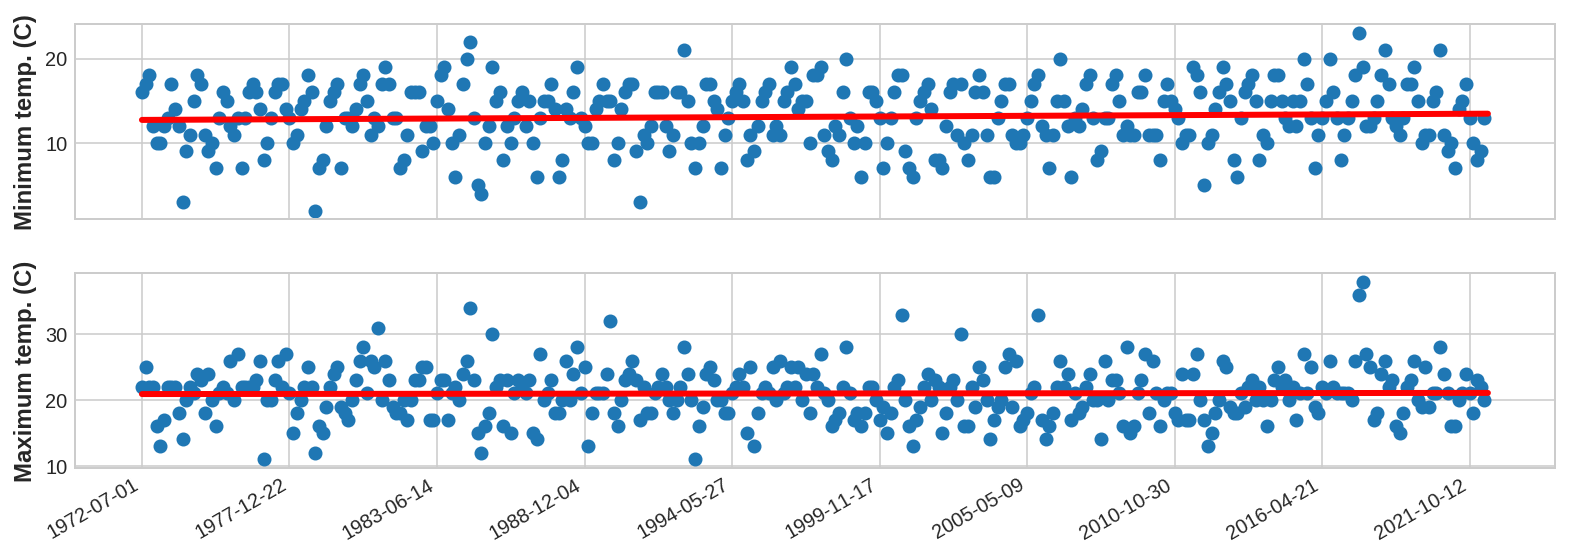

In [17]:
fig, axes = plt.subplots(2)
cols_0 = ["TMin"+unit, "TMax"+unit] # For processing
cols = [ "Min Prediction", "Max Prediction"] # For Graphing
y_labels = ["Minimum temp. ("+unit+")", "Maximum temp. ("+unit+")"]

for i, col in enumerate(cols):
  axes[i].plot(y_pred_trend[col], color="red", linewidth=3) 

  # plot once for each (skip_days) days
  axes[i].scatter(weather_data[::skip_days].index, weather_data[::skip_days][cols_0[i]])
  axes[i].set_ylabel(y_labels[i])
  axes[i].xaxis.set_major_locator(plt.MaxNLocator(x_tick_step))
  
fig.autofmt_xdate()
ax.set_title('Time Plot of Weather');

The slope and trend is not clear when drawn with scatters since the slope of line is too small; however, it gets more clear when drawn independently.

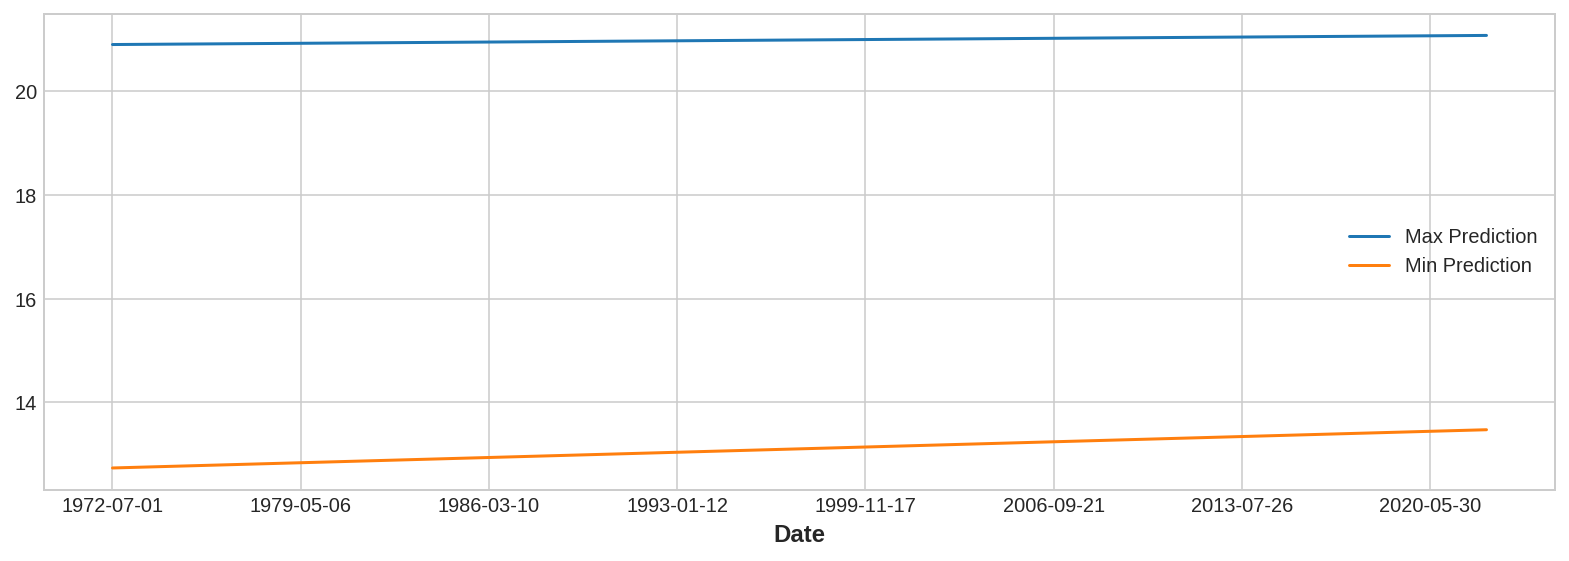

In [18]:
y_pred_trend.plot()

Numerical values for the slopes of those lines can be calculated by coef_ method.

In [19]:
print(model_min_trend.coef_)
print(model_max_trend.coef_)

[1.27331897e+01 4.04300170e-05]
[2.09014756e+01 9.62664582e-06]


as seen with coef_ values,

Trend of minimum temperatures is 40.43 μC*t + 12.7 C

Trend of maximum Temperatures is 9.62 μC*t + 20.90 C

(m --> (1/1000), C --> Celcius, t --> number of days passed from 1972, July)

This means minimum temperatures are increasing **4 times more (40.43 uC/9.62 uC)** than maximum temperatures. This fact implies that day and night temperatures are getting closer. 

Over the 50 years period maximum daily temperatures have been increased by 50* 365.25 * 9.62 μC = 0.176 Celcius Degrees
Over the 50 years period minimum daily temperatures have been increased by 50* 365.25 * 40.43 μC = 0.738 Celcius Degrees

### Seasonality

Seasonality is the regular periodic change in the mean of time series. For weather prediction, a typical seasonality time frame would be a year.

Seasonal indicators can be used to predict short term(daily, weekly) seasonal patterns, while Fourier series can be used for discovering longer time(a few months or more) seasonal patterns.

A periodogram is an estimate of the spectral density of signals ([Source](https://en.wikipedia.org/wiki/Periodogram)). 

It can be used to discover which frequency(i.e. annual, monthly, weekly etc.) is dominant in the time series.

plot_periodogram function below is for discovering which frequencies are more influential in the seasonal patterns observed in weather data. 

In [20]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


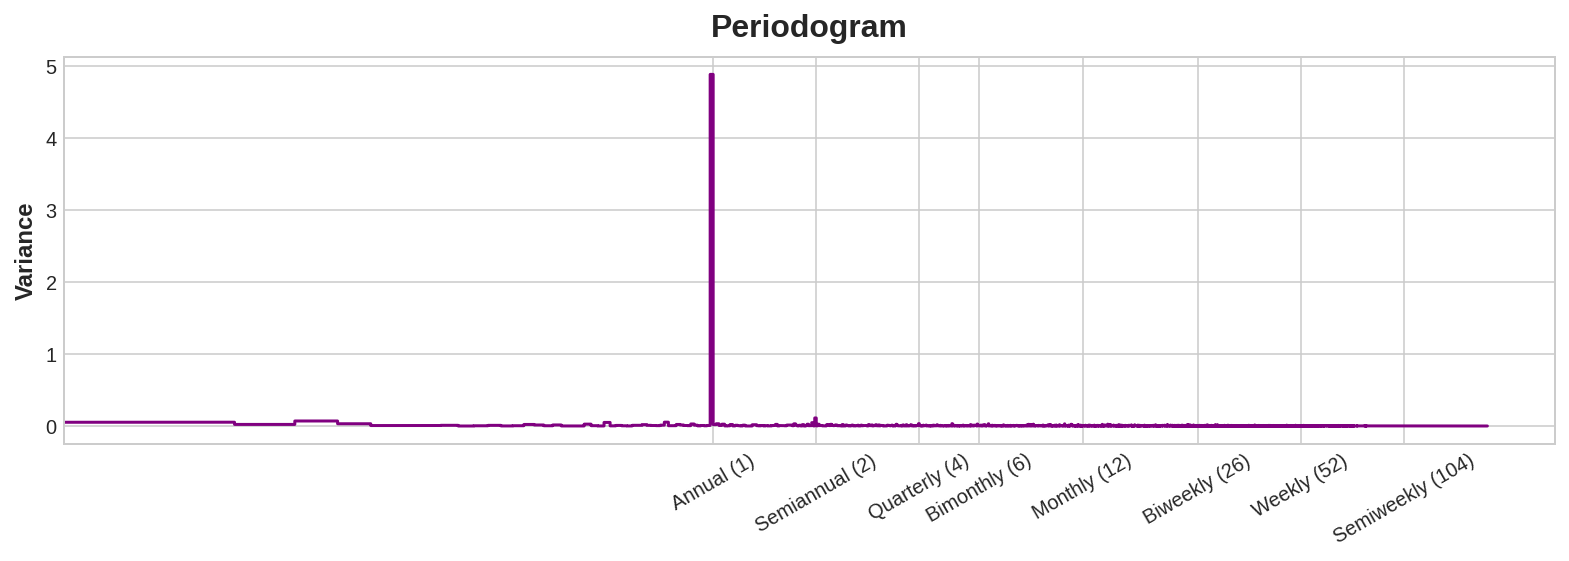

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


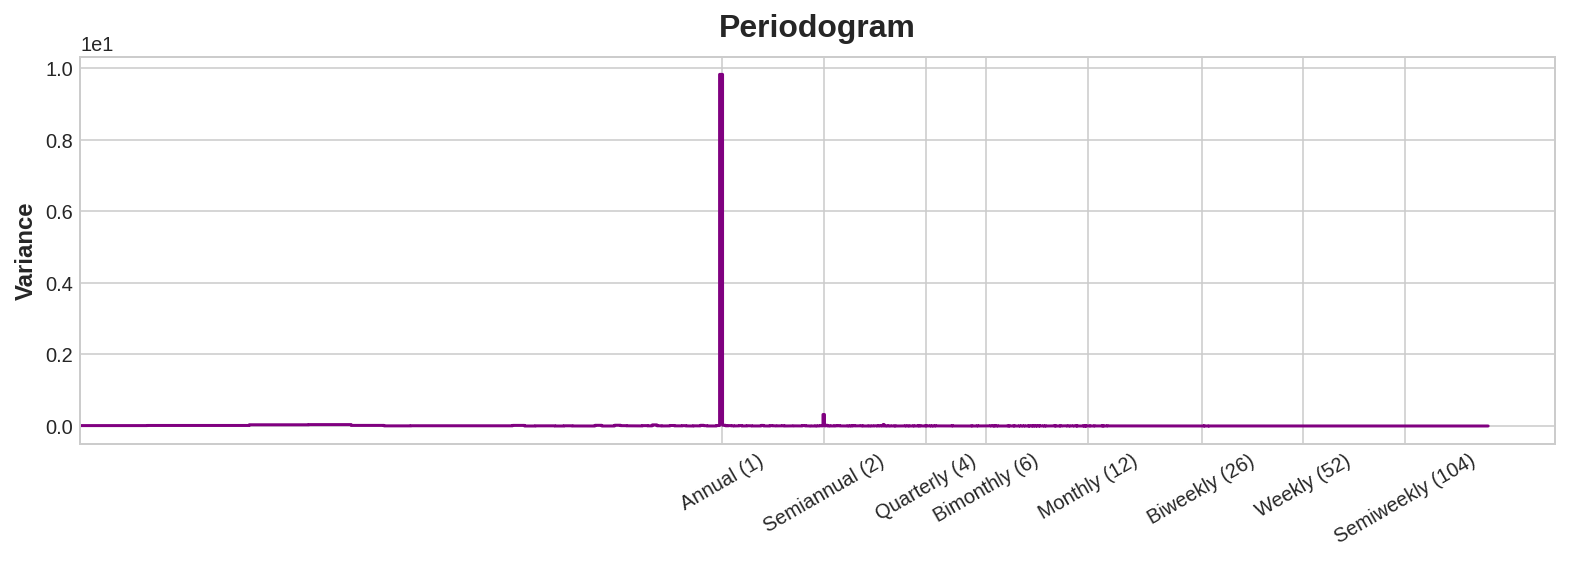

In [21]:
plot_periodogram(weather_data["TMax"+unit])
plt.show()
plot_periodogram(weather_data["TMin"+unit])
plt.show()

Two periodograms have been drawn above. The graph on the top shows the periodogram for maximum temperature, and the one below shows the periodogram for minimum temperature.

As seen from Periodogram graphs above, weather data shows a strong **annual** seasonality pattern. Therefore, **fourier series** will be used to calculate seasonality.

Currently, the index is in the type of object; to work with CalenderFourier, it needs to converted into pd.datetime datatype. Next cell makes the conversion.

In [22]:
weather_data.index = weather_data.index.map(lambda x: pd.to_datetime(x))

A fourier series is the sum of some trigonometric functions. For the purposes of weather forecasting, 12 sinus/cosinus pairs will be used.

In [71]:
fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

dp_seasonal = DeterministicProcess(
    index=weather_data.index.to_period(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                    # drop terms to avoid collinearity
)

X = dp_seasonal.in_sample()

Two linear regression models have been used to predict Maximum and Minimum temperatures.

In [24]:
# Defining targets
y_max = weather_data["TMax"+unit]
y_min = weather_data["TMin"+unit]

# Defining models
model_max_seasonal = LinearRegression(fit_intercept = False)
model_min_seasonal = LinearRegression(fit_intercept = False)

# Fitting models over existing data
model_max_seasonal.fit(X, y_max)
model_min_seasonal.fit(X, y_min)

# Defining Forecast Horizon
X_fore = dp_seasonal.out_of_sample(steps=200)

# Making predictions on historical data
y_pred_max_seasonal = pd.Series(model_max_seasonal.predict(X), index = y_max.index)
y_pred_min_seasonal = pd.Series(model_min_seasonal.predict(X), index = y_min.index)

# Making forecasts
y_fore_max = pd.Series(model_max_seasonal.predict(X_fore), X_fore.index)
y_fore_min = pd.Series(model_min_seasonal.predict(X_fore), X_fore.index)

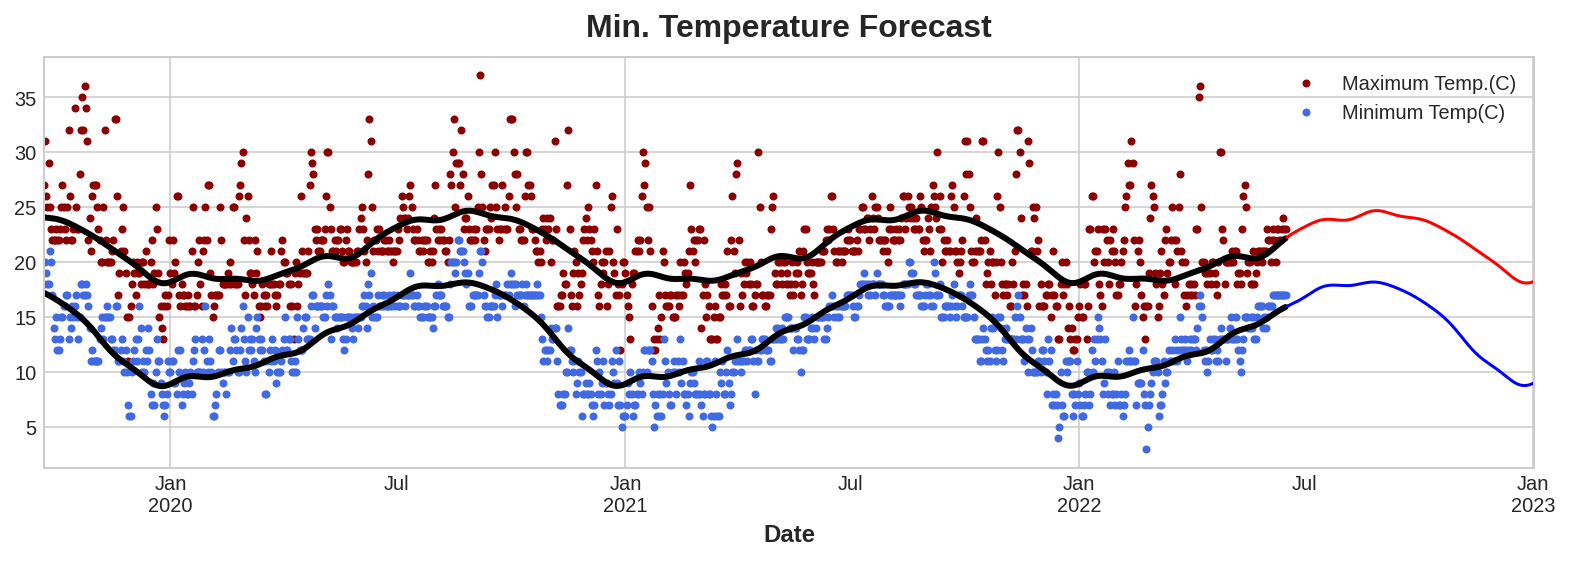

In [25]:
# Plotting
## Plotting last 1000 days to clearly see the data

### Drawing scatter points
ax = y_max[-1000:].plot(style=".", title="Max. Temperature Forecast", color="darkred")
ax = y_min[-1000:].plot(style=".", title="Min. Temperature Forecast", color="royalblue")

### Drawing the historically fitted lines
ax = y_pred_max_seasonal[-1000:].plot(ax=ax, label="Seasonal", linewidth=3, color="black")
ax = y_pred_min_seasonal[-1000:].plot(ax=ax, label="Seasonal", linewidth=3, color="black")

### plotting next 200 day forecasts in red
ax = y_fore_max.plot(ax=ax, label="Seasonal Forecast", color="red")
ax = y_fore_min.plot(ax=ax, label="Seasonal Forecast", color="blue")
plt.legend(["Maximum Temp.("+unit+")", f"Minimum Temp({unit})"],loc=1)

#### DETRENDING

Detrending the data may give better results for calculating seasonality. Next cells will measure seasonality on de-trended data.

In [26]:
# Defining targets
y_pred_trend_max = y_pred_trend["Max Prediction"]
y_pred_trend_min = y_pred_trend["Min Prediction"]

In [27]:
# Changing indexes of series to datetime
y_pred_trend_max.index = y_pred_trend_max.index.map(pd.to_datetime)
y_pred_trend_min.index = y_pred_trend_min.index.map(pd.to_datetime)
y_max.index = y_max.index.map(pd.to_datetime)
y_min.index = y_min.index.map(pd.to_datetime)

In [28]:
# Finding detrended series by substracting the trend line from the data
y_detrended_max = y_max - y_pred_trend_max
y_detrended_min = y_min - y_pred_trend_min

Plotting detrended series allows the seasonality to be clearly seen.

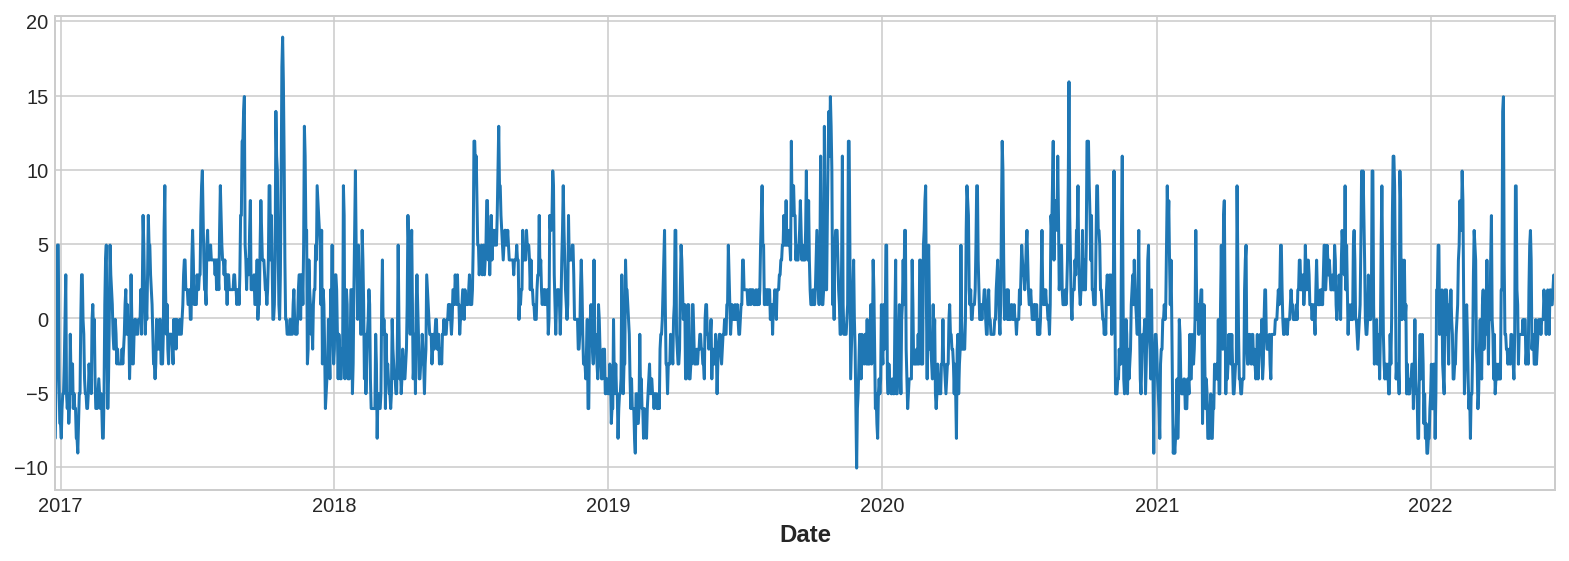

In [29]:
y_detrended_max[-2000:].plot() # Plotting last 2000 days to see seasonality better

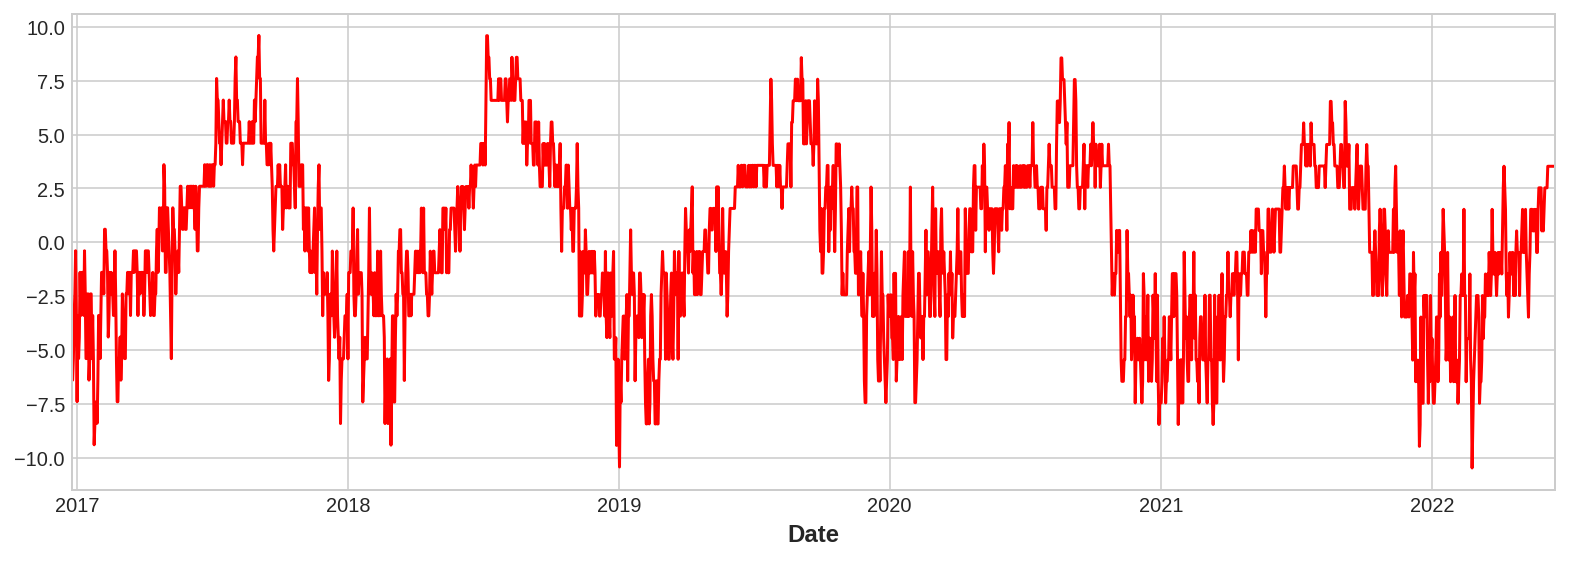

In [30]:
y_detrended_min[-2000:].plot(color="red")

In [31]:
fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

dp_detrended_seasonal = DeterministicProcess(
    index=weather_data.index.to_period(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                    # drop terms to avoid collinearity
)

X = dp_detrended_seasonal.in_sample()

In [32]:
# Defining targets
max_t = y_detrended_max
min_t = y_detrended_min

# Defining models
model_max_detrended_seasonal = LinearRegression(fit_intercept = False)
model_min_detrended_seasonal = LinearRegression(fit_intercept = False)

# Fitting models over existing data
model_max_detrended_seasonal.fit(X, max_t)
model_min_detrended_seasonal.fit(X, min_t)

# Defining Forecast Horizon
X_fore = dp_detrended_seasonal.out_of_sample(steps=200)

# Making predictions on historical data
y_pred_max_seasonal = pd.Series(model_max_detrended_seasonal.predict(X), index = y_max.index)
y_pred_min_seasonal = pd.Series(model_min_detrended_seasonal.predict(X), index = y_min.index)

# Making forecasts
y_fore_max = pd.Series(model_max_detrended_seasonal.predict(X_fore), X_fore.index)
y_fore_min = pd.Series(model_min_detrended_seasonal.predict(X_fore), X_fore.index)

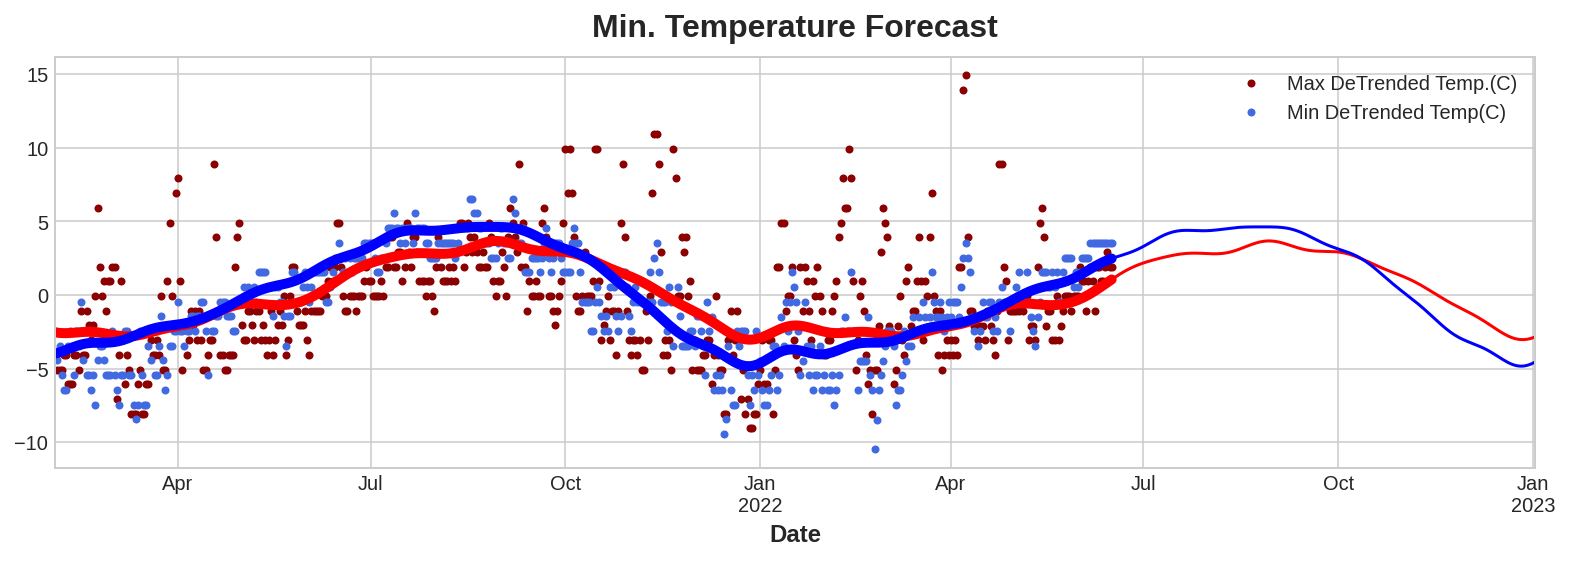

In [33]:
# Plotting detrended seasonalities
## Plotting last 500 days to clearly see the data

### Drawing scatter points
ax = y_detrended_max[-500:].plot(style=".", title="Max. Temperature Forecast", color="darkred")
ax = y_detrended_min[-500:].plot(style=".", title="Min. Temperature Forecast", color="royalblue")

### Drawing the historically fitted lines
ax = y_pred_max_seasonal[-500:].plot(ax=ax, label="Seasonal", linewidth=5, color="red")
ax = y_pred_min_seasonal[-500:].plot(ax=ax, label="Seasonal", linewidth=5, color="blue")

### plotting next 200 day forecasts in red
ax = y_fore_max.plot(ax=ax, label="Seasonal Forecast", color="red")
ax = y_fore_min.plot(ax=ax, label="Seasonal Forecast", color="blue")
plt.legend(["Max DeTrended Temp.("+unit+")", f"Min DeTrended Temp({unit})"],loc=1)

As seen from the figure above, maximum de-trended and minimum de-trended temperatures intersect near equinoxes (March 21st and Sept. 23rd)
That's because at those days are equinoxes.

### DESEASONING
Removing the observed seasonal affects may increase the accuracy of next methods. Therefore, the next cells will remove seasonal effects.

In [34]:
y_deseasoned_max = y_detrended_max - y_pred_max_seasonal
y_deseasoned_min = y_detrended_min - y_pred_min_seasonal

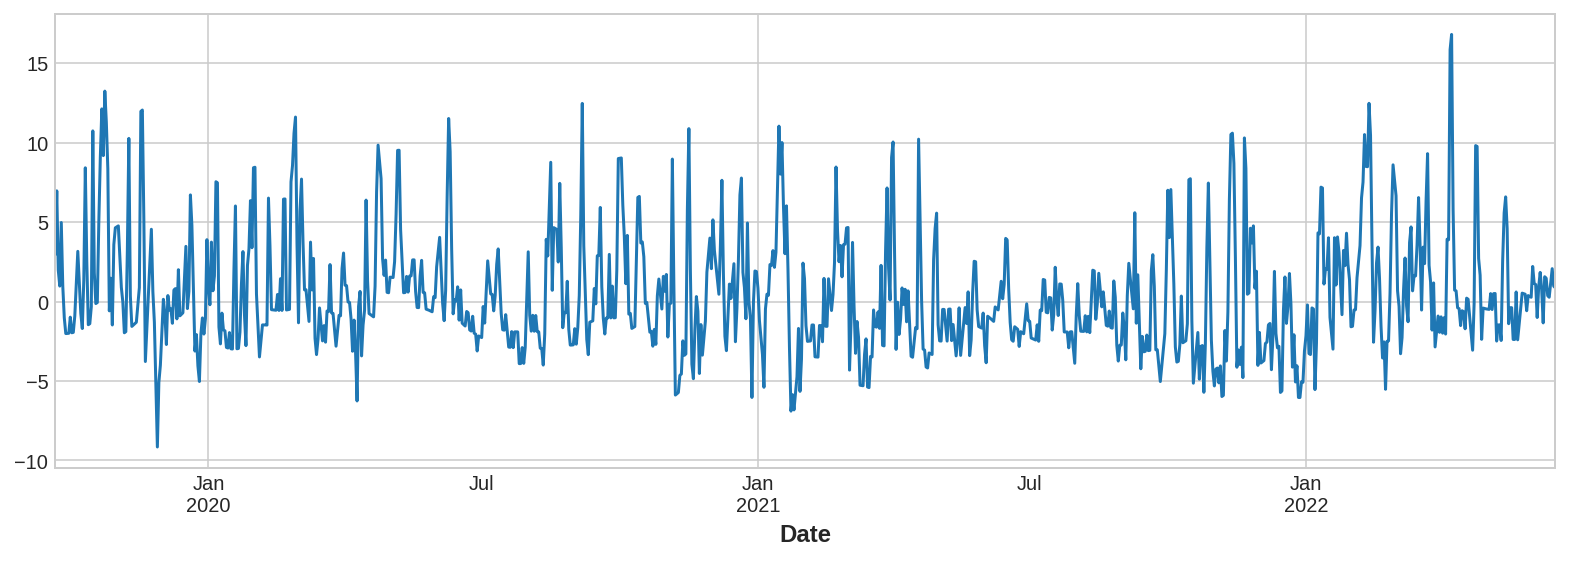

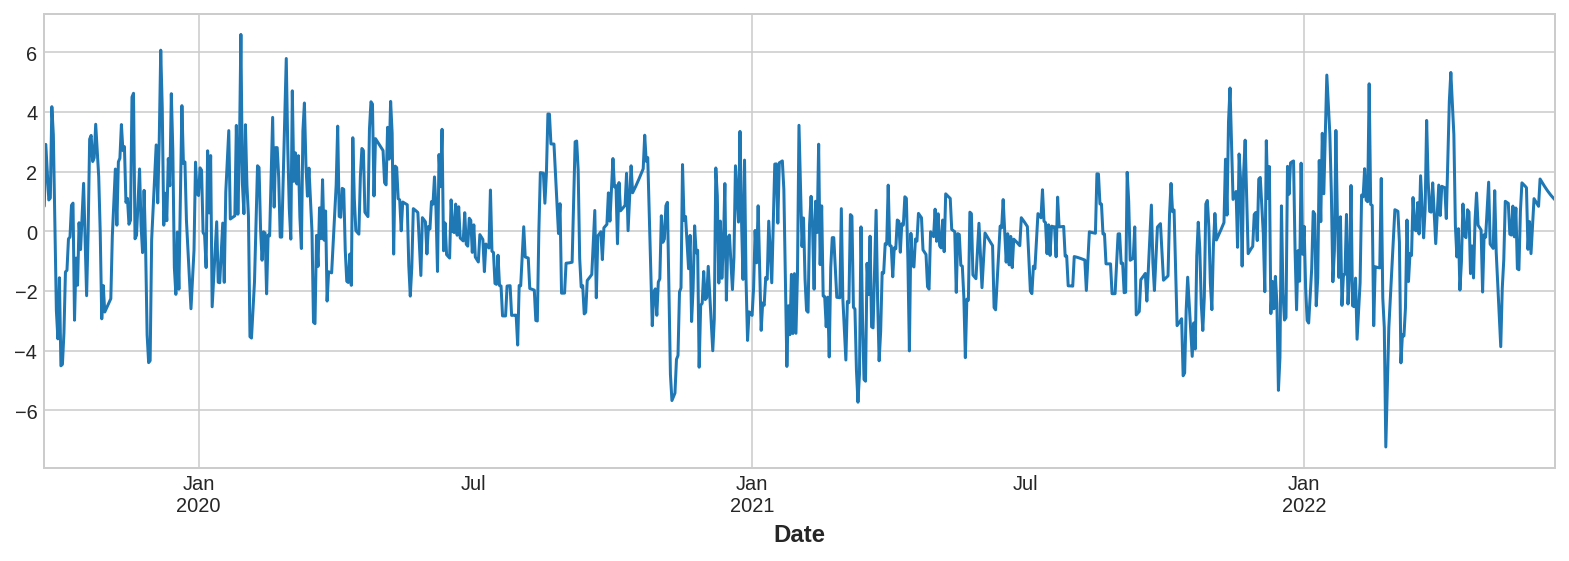

In [35]:
# Plotting last 1000 day de-trended and de-seasoned data
## max
y_deseasoned_max[-1000:].plot()
plt.show()

## min
y_deseasoned_min[-1000:].plot()
plt.show()

### Time Series as Features( Cycles)
There may be some serial dependencies in the data that are not time dependent like seasonality. Detecting and removing those cycles in the de-seasoned data will give us residues (unpredictable error).

#### Lag Series and Lag Plots

Lagged values and partial auto-correlation values for both un-manipulated data and de-seasoned data will be calculated in the following cells.

In [36]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


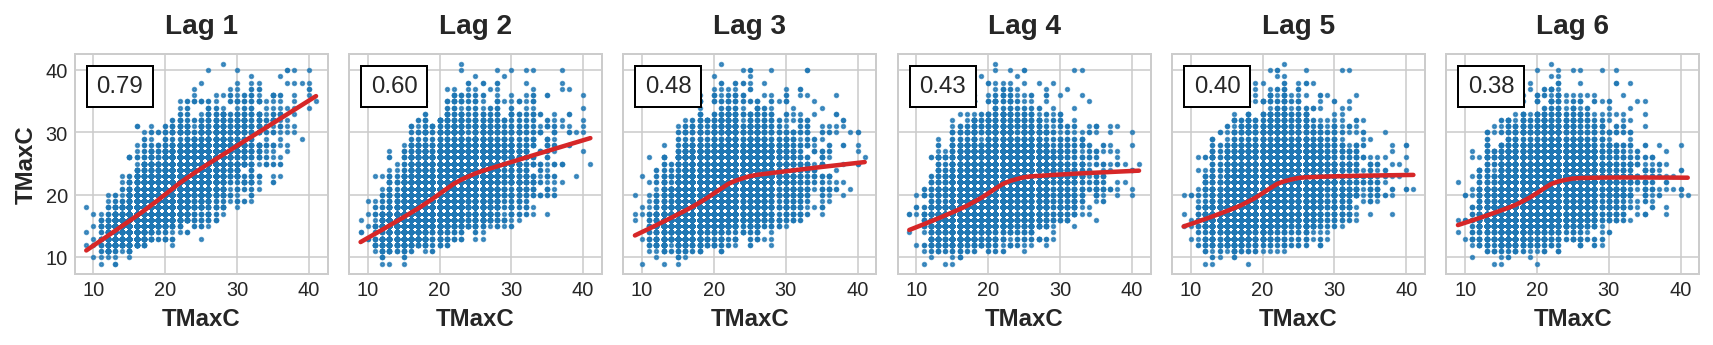

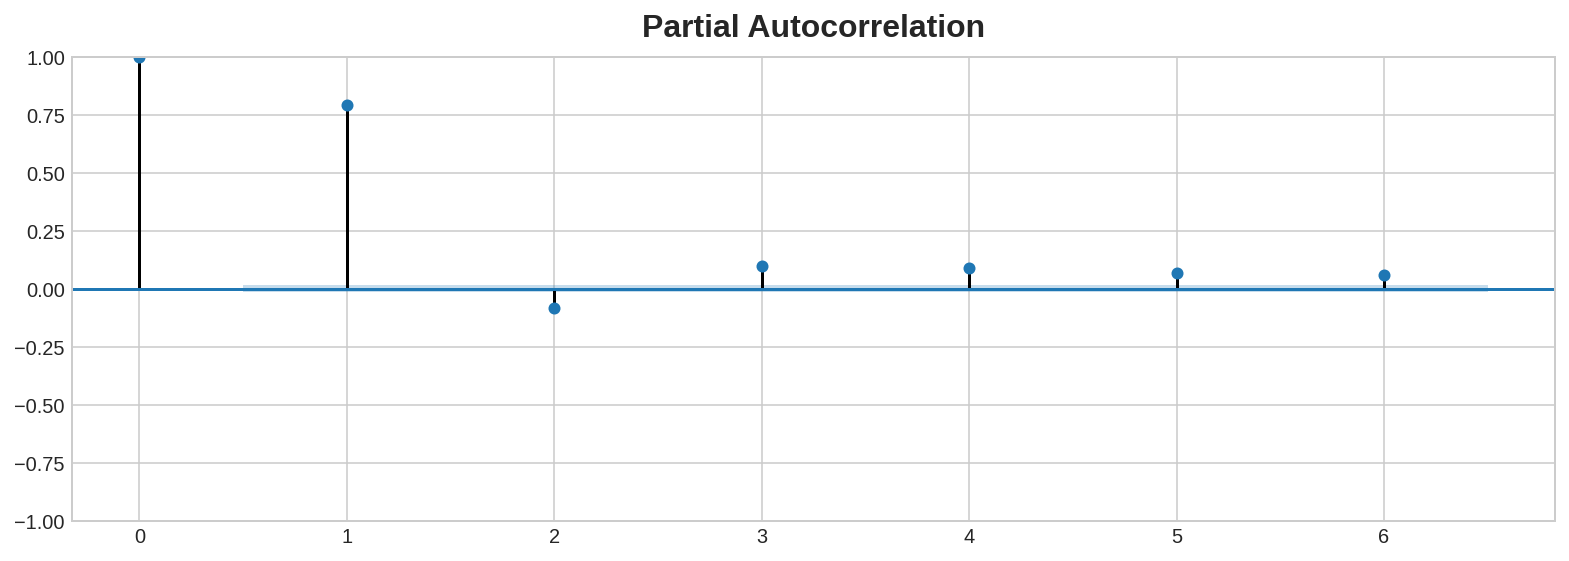

In [37]:
_ = plot_lags(weather_data["TMax"+unit])
_ = plot_pacf(weather_data["TMax"+unit], lags=6)

In [38]:
print("Mean: ",weather_data["TMax"+unit].mean())
print("Median: ",weather_data["TMax"+unit].median())

Mean:  20.989313897413414
Median:  21.0


The lag plots indicate that the relationship is mostly linear and the partial autocorrolation graph implies that only the first lag can be used to predict maximum temperature.

It can be observed from lag plots that graphs refract after some point. Also, the refraction becomes more clear as the number of lags inreases.

That's because linear relationship between target and lags only exist for temperatures below a limit (about 21 degrees celcius). That is observed because 21 degrees celcius is both mean and median of the series and there are much more data points closer to 21 degrees celcius.

The weather to stay in extreme temperatures gets less and less probable as more time goes by. Hence; as number of lags increases, the effect of non-linearity gets more clear.

A similar effect occurs for minimum temperatures at 13 degrees Celcius.

In [39]:
print("Mean: ",weather_data["TMin"+unit].mean())
print("Median: ",weather_data["TMin"+unit].median())

Mean:  13.102093380096449
Median:  13.0


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


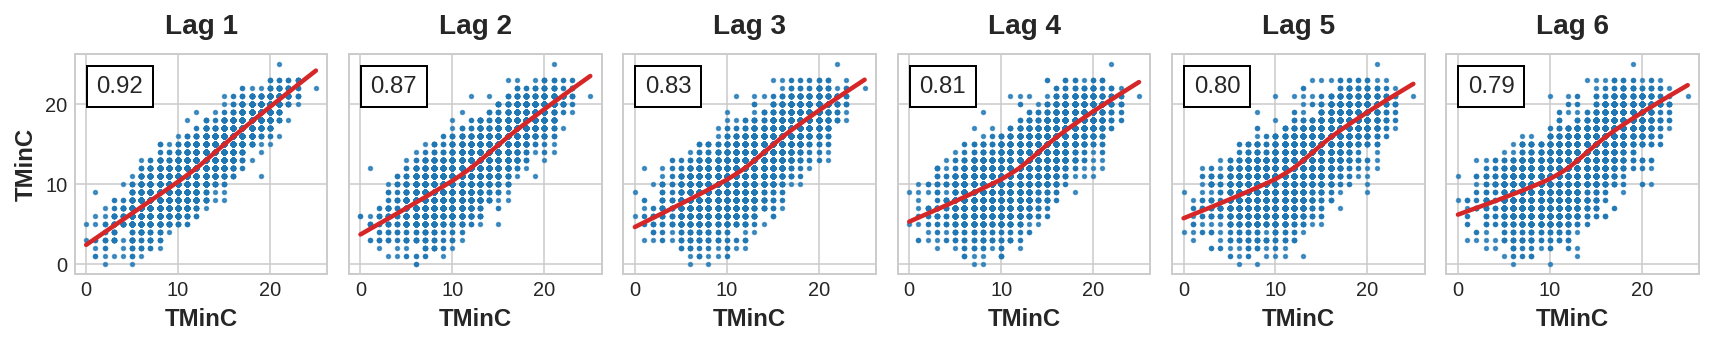

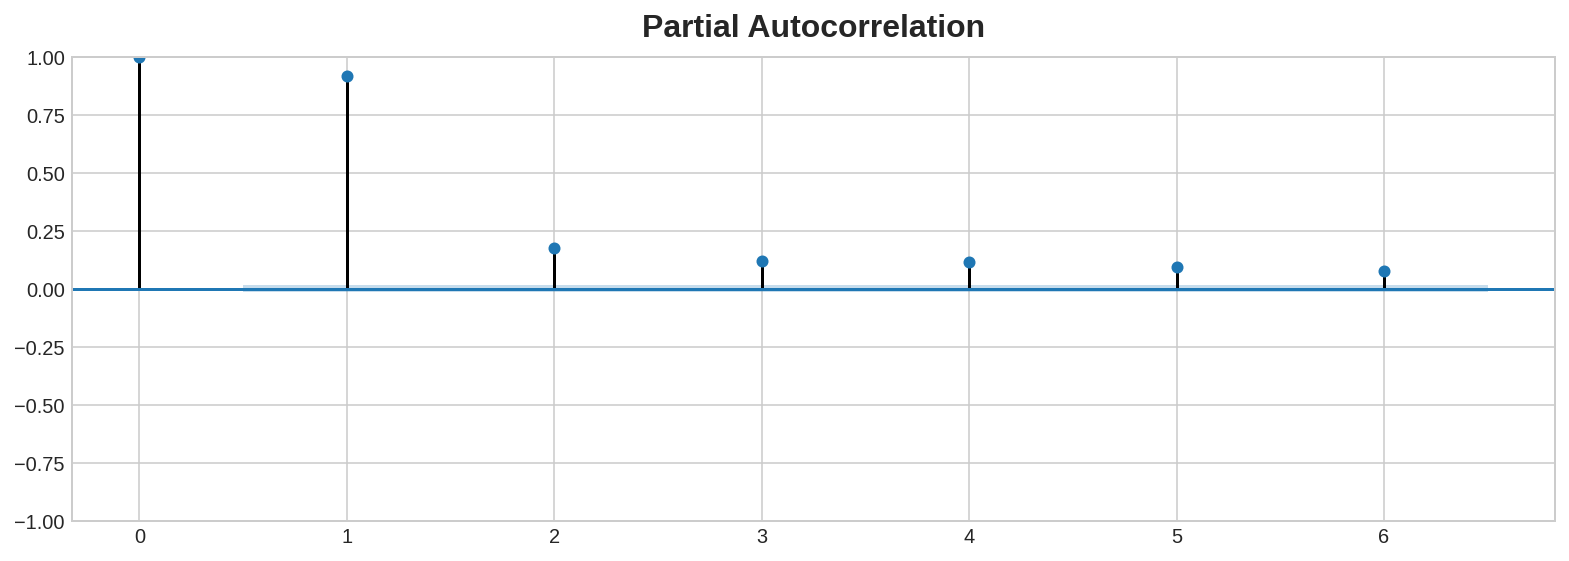

In [40]:
_ = plot_lags(weather_data["TMin"+unit])
_ = plot_pacf(weather_data["TMin"+unit], lags=6)

The above lag plots show that minimum temperature also has a linear relation with its lags.

Partial autocorrelation map shows that first two lags are more correlated with the target.

#### LAGGED Serial Dependence for deseasoned data.

Drawing lag plots and partial auto-correlation graph; it is clear that maximum temperature is mostly correlated with its first and second lags. While minimum temperatures are correlated with 1st and 4th lags.

In [41]:
lags = pd.DataFrame()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


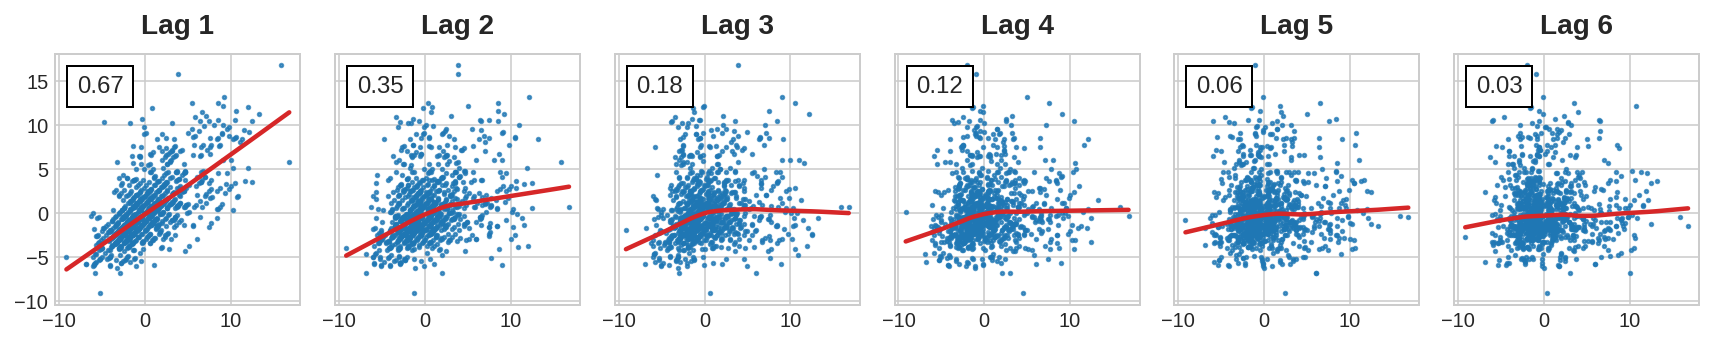

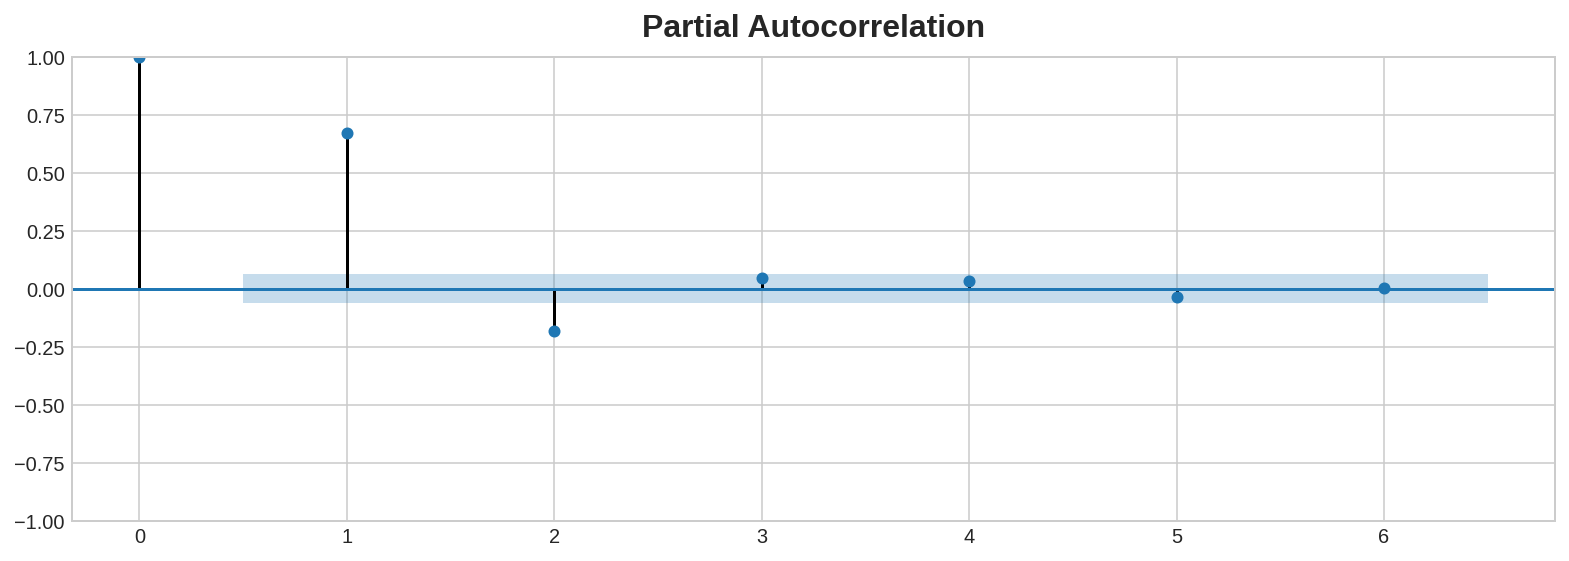

In [42]:
_ = plot_lags(y_deseasoned_max[-1000:])
_ = plot_pacf(y_deseasoned_max[-1000:], lags=6)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


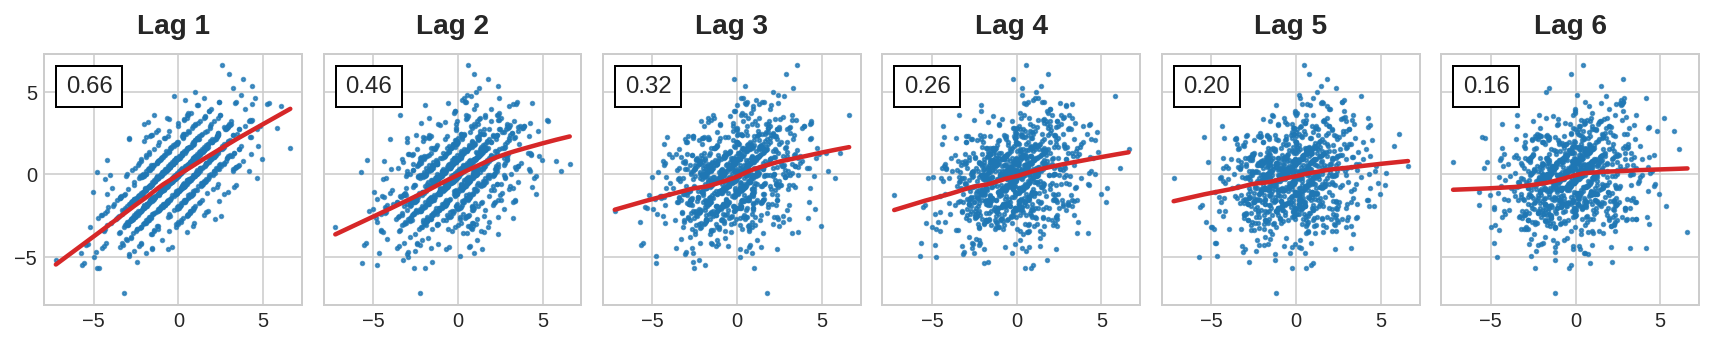

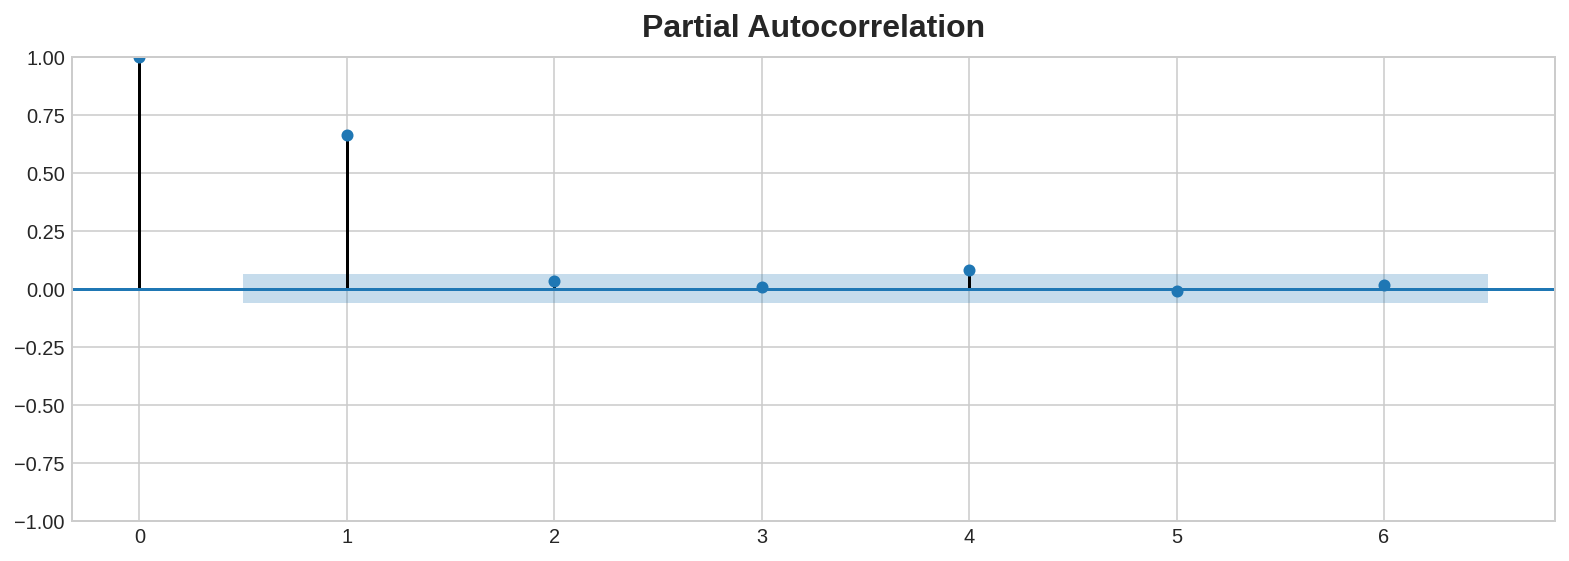

In [43]:
_ = plot_lags(y_deseasoned_min[-1000:])
_ = plot_pacf(y_deseasoned_min[-1000:], lags=6)

In [44]:
for i in range(1,3):
  # 2 lag columns for maximum temperature will be created
  lags["Lag_"+str(i)+"max"] = y_deseasoned_max.shift(i)

  # 2 lag columns for minimum temperature will be created
  lags["Lag_"+str(i)+"min"] = y_deseasoned_min.shift(i)

In [45]:
lags = lags.fillna(0.0)
lags

,Lag_1max,Lag_1min,Lag_2max,Lag_2min
Date,,,,
1972-07-01,0.000000,0.000000,0.000000,0.000000
1972-07-02,-0.998195,0.040574,0.000000,0.000000
1972-07-03,-2.044280,-0.039353,-0.998195,0.040574
1972-07-04,-2.088133,-0.121300,-2.044280,-0.039353
1972-07-05,-1.130053,-0.204402,-2.088133,-0.121300
...,...,...,...,...
2022-06-12,0.367086,1.358016,1.464775,1.431613
2022-06-13,0.268024,1.288457,0.367086,1.358016
2022-06-14,1.168149,1.223103,0.268024,1.288457


In [46]:
y_max = y_deseasoned_max
X_train, X_test, y_train, y_test = train_test_split(lags, y_max, test_size= 100, shuffle= False)

model_time_series_max = LinearRegression()
model_time_series_max.fit(X_train, y_train)
y_pred_cyclic_max = pd.Series(model_time_series_max.predict(X_train), index=y_train.index)
y_fore_cyclic_max = pd.Series(model_time_series_max.predict(X_test), index=y_test.index)

In [47]:
y_min = y_deseasoned_min
X_train, X_test, y_train, y_test = train_test_split(lags, y_min, test_size=100, shuffle=False)
model_time_series_min = LinearRegression()
model_time_series_min.fit(X_train, y_train)

y_pred_cyclic_min = pd.Series(model_time_series_min.predict(X_train), index=y_train.index)
y_fore_cyclic_min = pd.Series(model_time_series_min.predict(X_test), index = y_test.index)

In [48]:
def make_lags(ts_max, ts_min, lags, lead_time=1):
    lags_dict = {f"Lag_{i}max": ts_max.shift(i) for i in range(lead_time, lags + lead_time)}
    lags_dict.update({f"Lag_{i}min": ts_min.shift(i) for i in range(lead_time, lags + lead_time)})
    return pd.DataFrame(lags_dict).fillna(0)

Following code cells will make lags for both maximum and minimum de-seasonalized temperatures.

In [49]:
make_lags(y_deseasoned_max, y_deseasoned_min, lags=2,lead_time = 1)

,Lag_1max,Lag_2max,Lag_1min,Lag_2min
Date,,,,
1972-07-01,0.000000,0.000000,0.000000,0.000000
1972-07-02,-0.998195,0.000000,0.040574,0.000000
1972-07-03,-2.044280,-0.998195,-0.039353,0.040574
1972-07-04,-2.088133,-2.044280,-0.121300,-0.039353
1972-07-05,-1.130053,-2.088133,-0.204402,-0.121300
...,...,...,...,...
2022-06-12,0.367086,1.464775,1.358016,1.431613
2022-06-13,0.268024,0.367086,1.288457,1.358016
2022-06-14,1.168149,0.268024,1.223103,1.288457


In [50]:
y_cyclic_max = pd.concat([y_pred_cyclic_max, y_fore_cyclic_max])

In [51]:
y_cyclic_min = pd.concat([y_pred_cyclic_min, y_fore_cyclic_min])

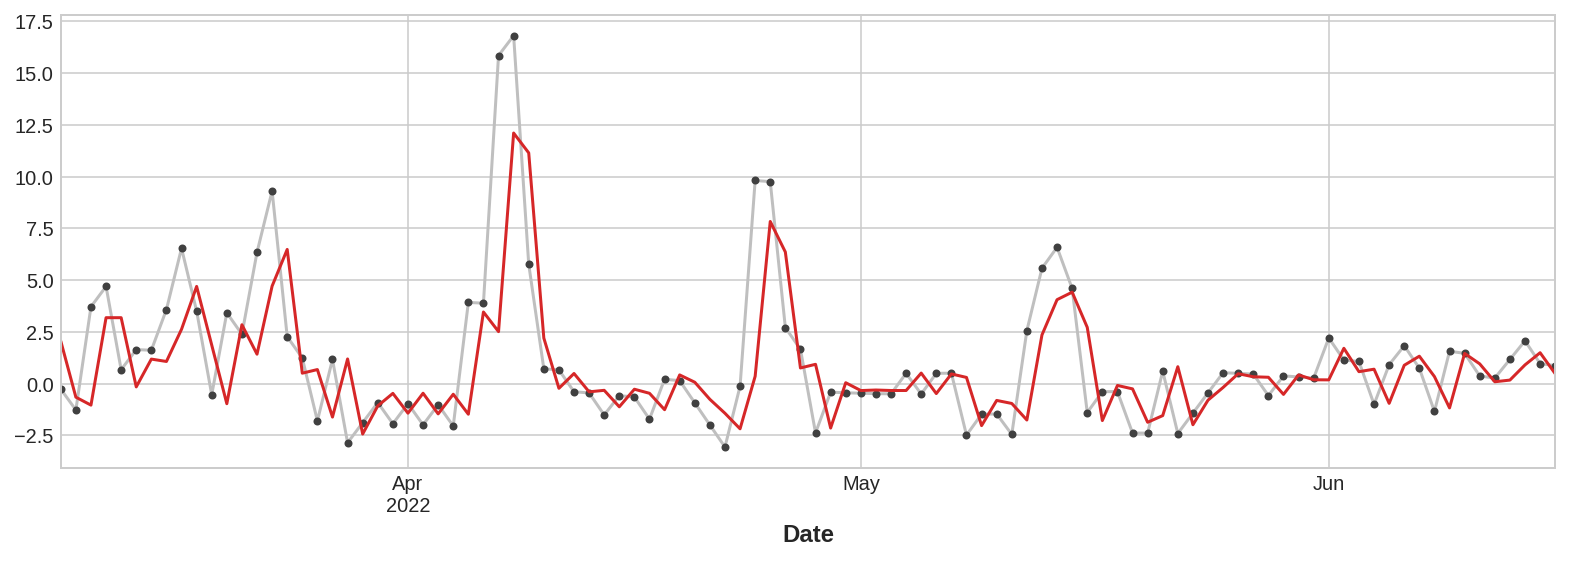

In [52]:
# Following graph is cycles for maximum temperatures data
ax = y_deseasoned_max[-100:].plot(**plot_params)
ax = y_cyclic_max[-100:].plot(ax=ax, color="C3")

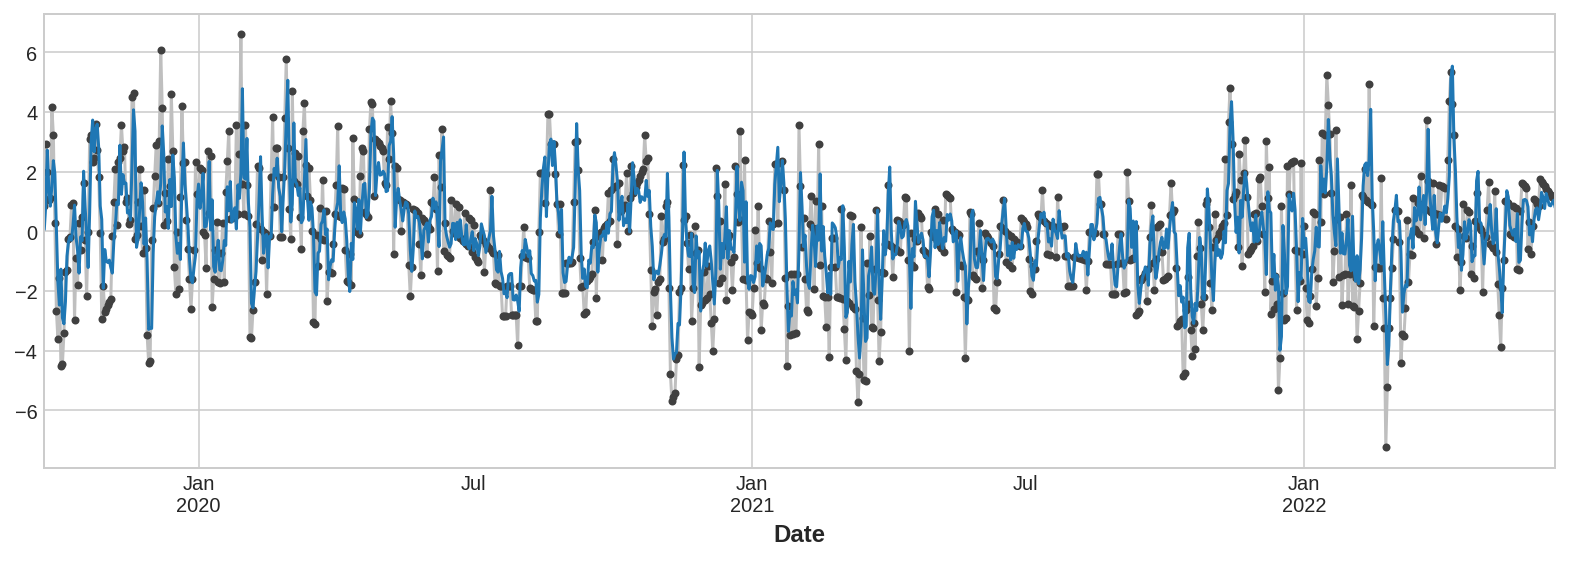

In [53]:
ax = y_deseasoned_min[-1000:].plot(**plot_params) # De-seasoned minimum temperatures
ax = y_cyclic_min[-1000:].plot(ax=ax)

### Residues
After removing trend, seasonality and cycles; the remaining part is residues( unpredictable error)

The unpredictable error is about of 0.001 Celcius degrees. So it's negligible for general.

In [54]:
y_resid_max = y_deseasoned_max - y_cyclic_max

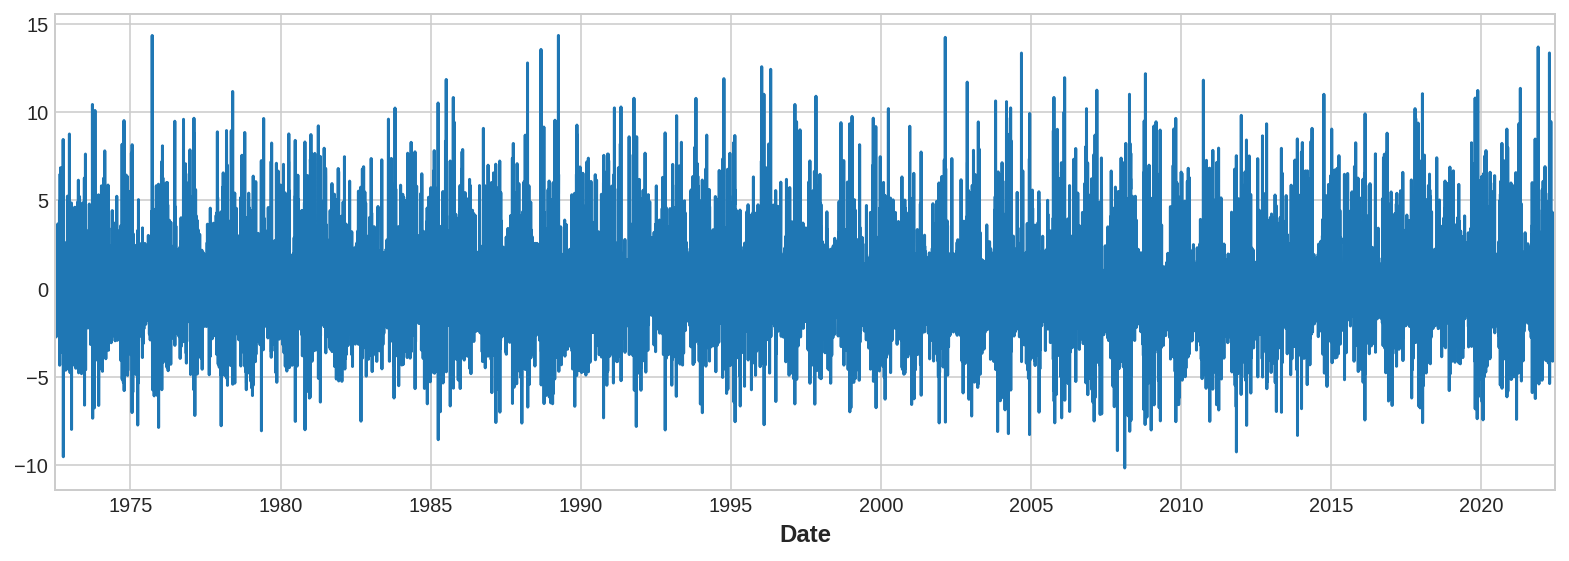

In [55]:
y_resid_max.plot() # Unpredictable error for max

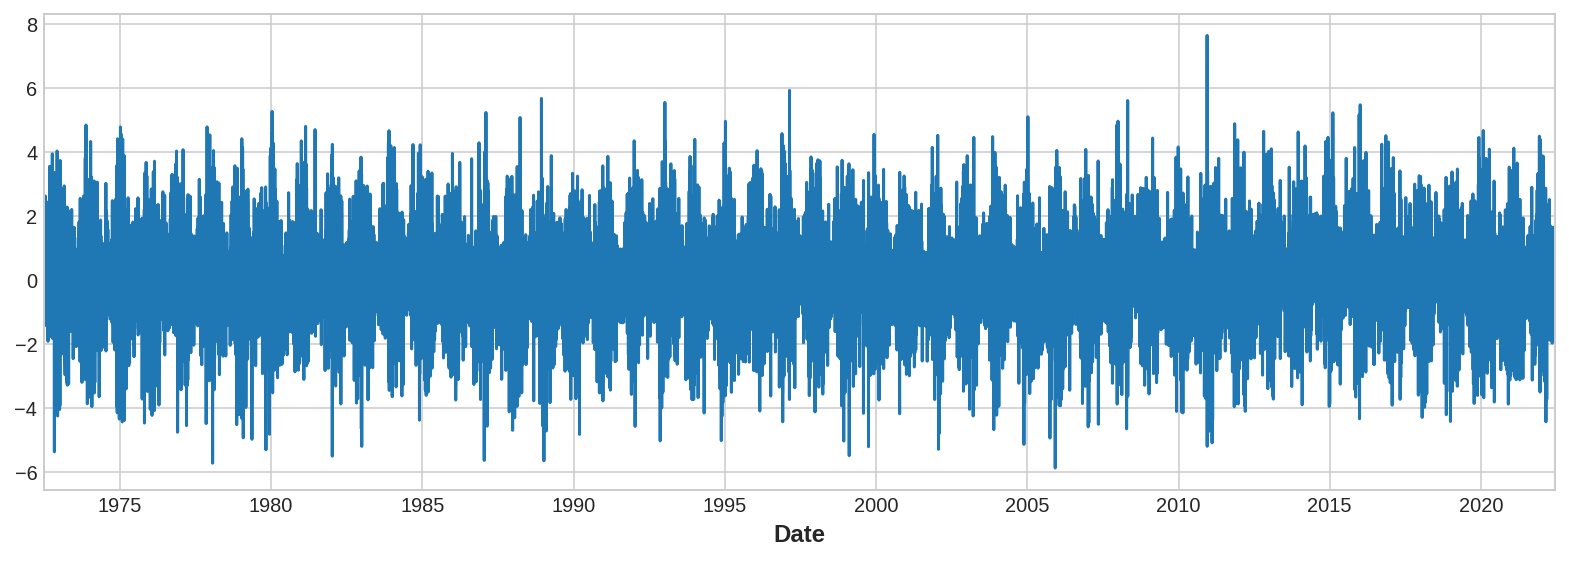

In [56]:
y_resid_min = y_deseasoned_min - y_cyclic_min
y_resid_min.plot() # Unpredictable error for min. temp.

In [57]:
print(y_resid_min.mean()) # Average error for min. temperature
print(y_resid_max.mean()) # Average error for max temp.

0.00033441128635348726
0.00198592380414729


## Forecasting in Total

Different models have been used to predict trend, seasonality and cycles.

Forecast = Trend + Seasonality + Cycles + residue

The function below will sum the results of those forecasts to get a functional single number.


In [58]:
y = pd.concat([y_train, y_test])

In [59]:
def forecast(date = y.index[-1], n_days = 31):
  # This function makes n_days time-step forecasts with the forecast horizon of date
  forecast_results = pd.DataFrame()
  dates = [date + pd.Timedelta(days = i) for i in range(1, n_days + 1)]
  # Method: predict by each model independently and then sum it up
  trend_forecast_max = pd.Series(model_max_trend.predict(dp_trend.out_of_sample(n_days)))
  seasonal_forecast_max = pd.Series(model_max_detrended_seasonal.predict(dp_seasonal.out_of_sample(n_days)))
  cyclic_forecast_max = pd.Series(model_time_series_max.predict(make_lags(y_deseasoned_max,y_deseasoned_min, lags=2, lead_time = 1).fillna(0)))
  forecast_max = (trend_forecast_max + seasonal_forecast_max + cyclic_forecast_max[:n_days] + y_resid_max.mean())
  forecast_results["Maximum temp. (" + unit+")"] =forecast_max

  trend_forecast_min = pd.Series(model_min_trend.predict(dp_trend.out_of_sample(n_days)))
  seasonal_forecast_min = pd.Series(model_min_detrended_seasonal.predict(dp_seasonal.out_of_sample(n_days)))
  cyclic_forecast_min = pd.Series(model_time_series_min.predict(make_lags(y_deseasoned_max,y_deseasoned_min, lags=2, lead_time = 1).fillna(0)))
  forecast_min = (trend_forecast_min + seasonal_forecast_min + cyclic_forecast_min[:n_days] + y_resid_min.mean())
  forecast_results["Minimum temp. (" + unit+")"] =forecast_min
  forecast_results.index = dates

  return forecast_results

In [62]:
simplefilter("ignore")
forecast().tail() # Make the forecasts from the model and show last 5 forecasts in the dataframe

,Maximum temp. (C),Minimum temp. (C)
2022-07-13,26.387209,18.975763
2022-07-14,27.195305,20.286211
2022-07-15,27.215732,20.877313
2022-07-16,28.408336,21.141455
2022-07-17,27.821852,22.404566


## Testing

To test the model; [Meteostat Data for LAX](https://meteostat.net/en/station/72295?t=2022-06-30/2022-07-07) will be used for the reason that NOAA data is missing temperature data for dates after 2nd of July as of the date of writing.

Following code will download the Meteostat data from personal drive.

(Meteostat data is available under the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License (CC BY-NC 4.0))

In [63]:
!gdown 1G2zWQDCW3maoBXCfEXX85DCKUdwBkQcv # Source: Meteostat Test data

Downloading...
From: https://drive.google.com/uc?id=1G2zWQDCW3maoBXCfEXX85DCKUdwBkQcv
To: /content/test_data_meteostat.csv
100% 1.48k/1.48k [00:00<00:00, 2.34MB/s]


Source: Meteostat

In [64]:
# reading MeteoStat data
test_data = pd.read_csv("test_data_meteostat.csv")

In [65]:
test_data.tail() # See last 5 measurements in test data

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
26,2022-07-13,18.3,16.7,21.0,0,NaN,266,16.0,NaN,1013.7,NaN
27,2022-07-14,19.4,17.8,22.0,0,NaN,267,13.0,NaN,1013.7,NaN
28,2022-07-15,19.7,17.8,21.9,0,NaN,253,14.1,NaN,1013.8,NaN
29,2022-07-16,20.9,18.5,25.0,0,NaN,251,12.0,NaN,1012.2,NaN
30,2022-07-17,21.2,18.9,25.7,0,NaN,252,12.0,NaN,1010.7,NaN


In [66]:
# Take max and min of all hours of the same day recorded
t_max_C_test = pd.Series(test_data.set_index("date")["tmax"])
t_min_C_test = pd.Series(test_data.set_index("date")["tmin"])

In [67]:
# Fixing dtypes of index
t_max_C_test.index = t_max_C_test.index.map(pd.to_datetime)
t_min_C_test.index = t_min_C_test.index.map(pd.to_datetime)

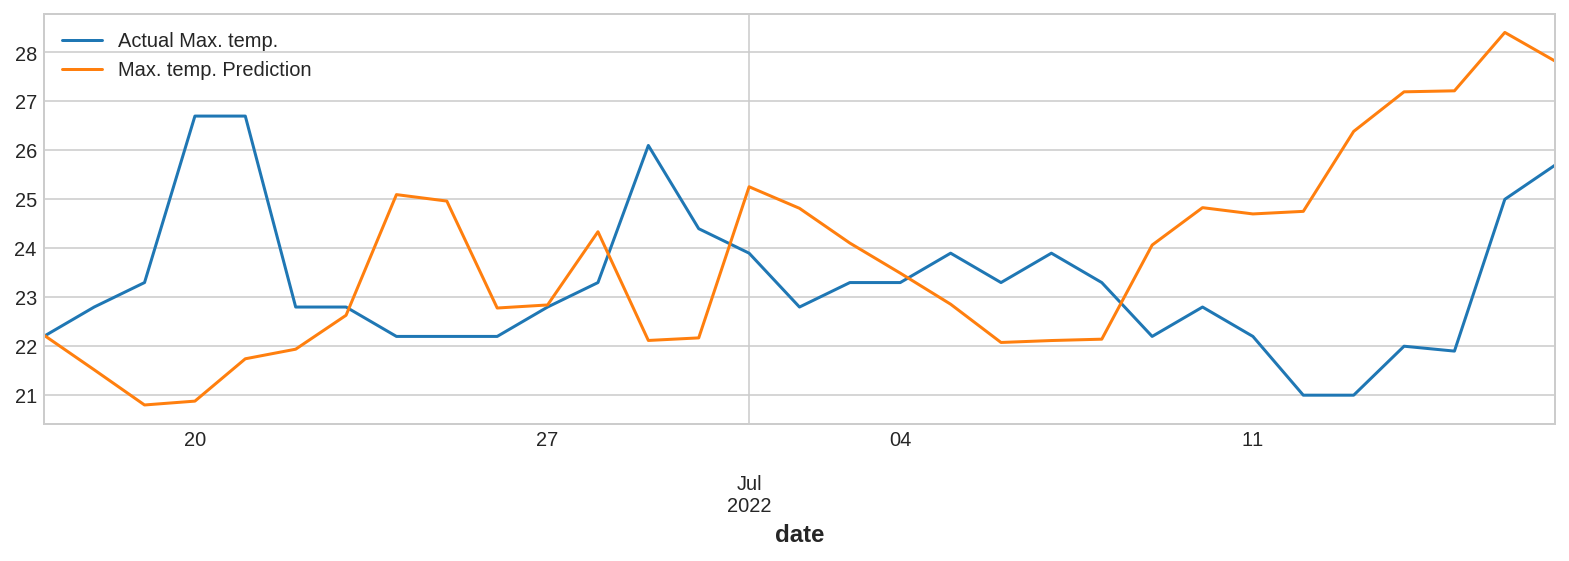

In [68]:
t_max_C_test.plot()
forecast()[f"Maximum temp. ({unit})"].plot()
plt.legend(labels=["Actual Max. temp.", "Max. temp. Prediction"])

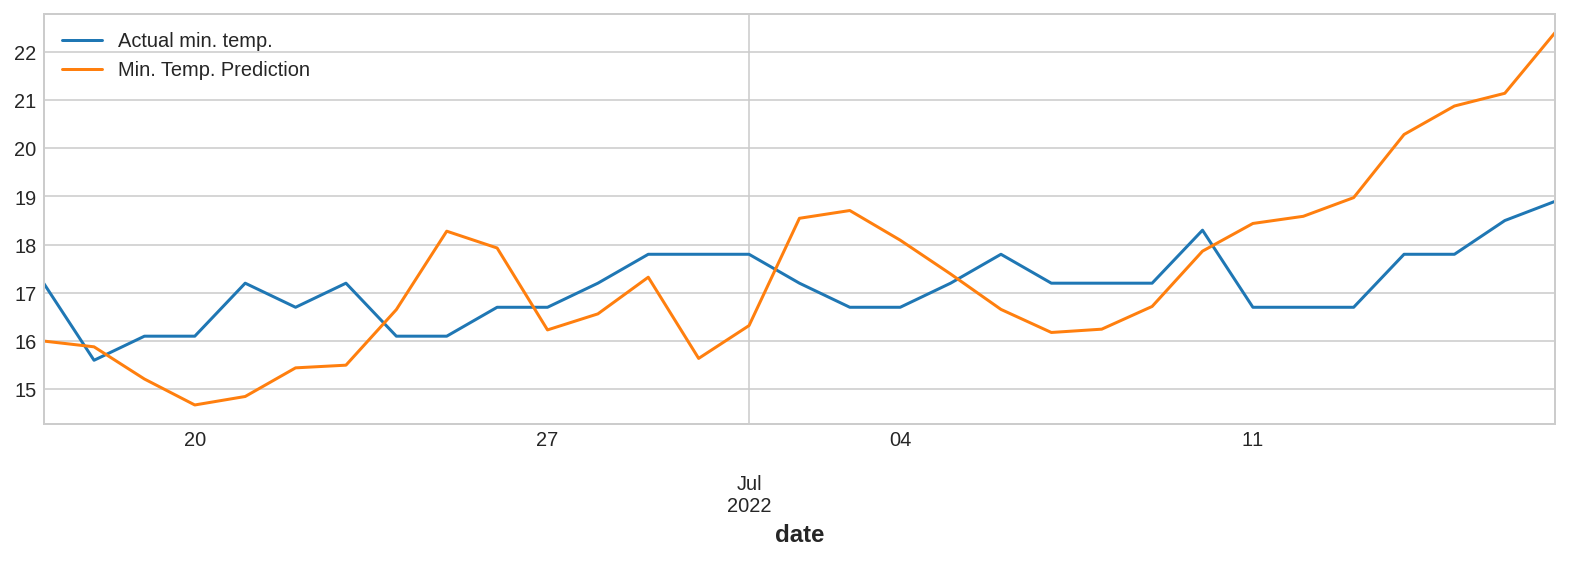

In [69]:
t_min_C_test.plot()
forecast()["Minimum temp. ("+unit+")"].plot()
plt.legend(labels=["Actual min. temp.", "Min. Temp. Prediction"])

### Measuring Performance


In [70]:
min_error = sqrt(mean_squared_error(forecast()["Minimum temp. ("+unit+")"], t_min_C_test))
max_error = sqrt(mean_squared_error(forecast()["Maximum temp. ("+unit+")"], t_max_C_test))

print("Minimum temperature RMSE: ", min_error)
print("Maximum temperature RMSE: ", max_error)

Minimum temperature RMSE:  1.6736120869610174
Maximum temperature RMSE:  2.825204918934012


Minimum temperature forecast has an error of 1.67 degrees Celcius, 

while maximum temperatures have an error of 2.85 degrees Celcius

## Ending Results
- There is one linear trend(global warming) on the long term temperatures.
- Global warming causes minimum daily temperatures to rise more than (about 4 times) daily maximum temperatures and causing daily temperature cap to narrow down
- Weather data is strongly seasonal over a year
- One-step temperature is 90% correlated with the daily data. Therefore, weather on the next day can be estimated with 90% accuracy.
- The monthly temperatures was forecasted with about 1.5 celcius average RMSE error